# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  6.1276445388793945


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs = imgs0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

#del(imgs)

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


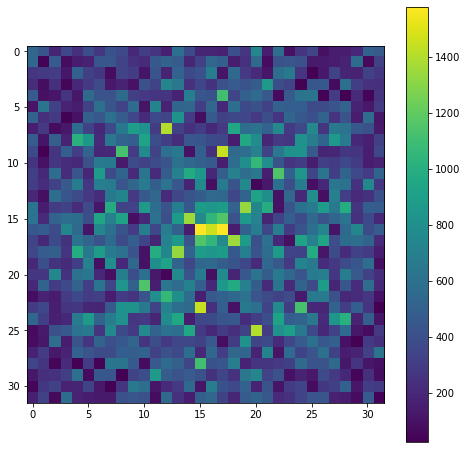

In [11]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

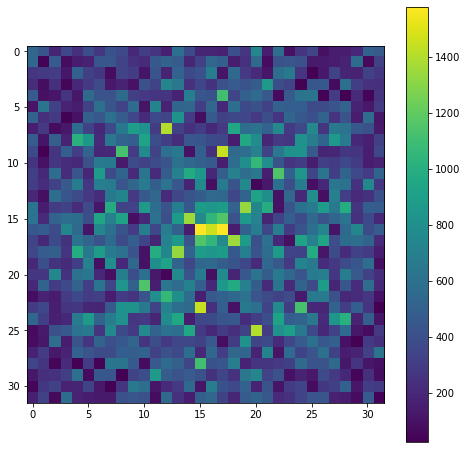

In [12]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

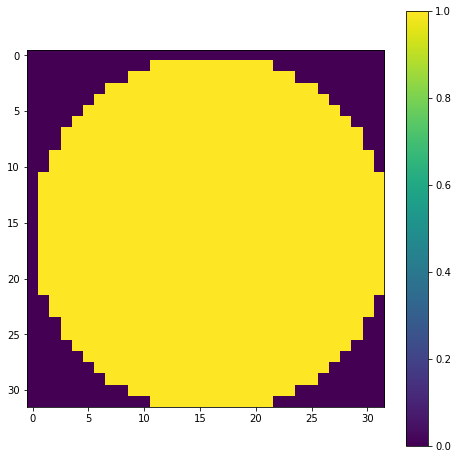

In [13]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Noise

First, decide on the dimensions of the empty corners to use for noise estimation:

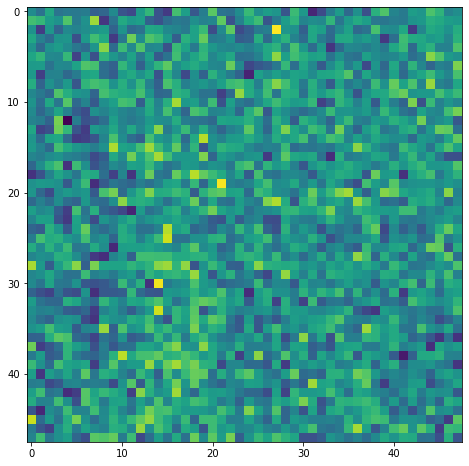

In [14]:
plt.imshow(jnp.mean(imgs0[:,:48,:48], axis=0))

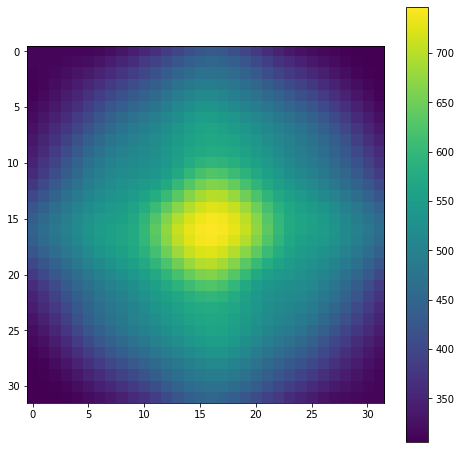

In [113]:
sigma_noise = estimate_noise_imgs(imgs0, nx_empty = 48, nx_final = 32)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

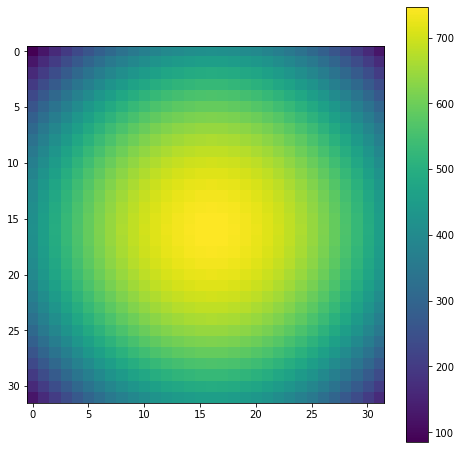

In [111]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise)-jnp.min(sigma_noise))*1.5/jnp.max(X**2+Y**2)
r = jnp.max(sigma_noise) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(r)); plt.colorbar()


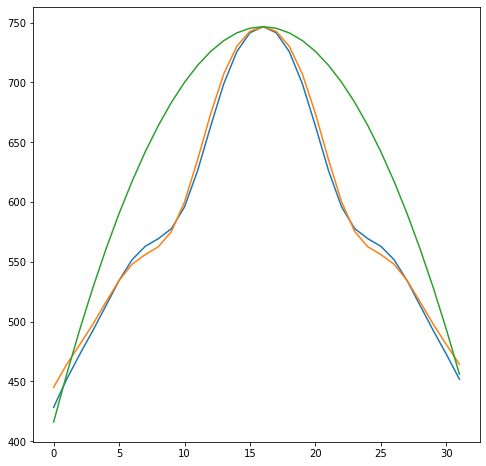

In [112]:
s = (sigma_noise.reshape([32,32]))
plt.plot(jnp.fft.fftshift(s[:,0]))
plt.plot(jnp.fft.fftshift(s[0,:]))
plt.plot(jnp.fft.fftshift(r[:,0]))

In [557]:
sigma_noise = r.reshape(-1)

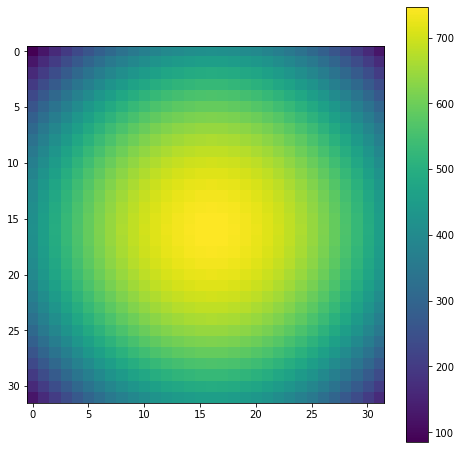

In [806]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))) ; plt.colorbar()

### Forward model and loss functon

In [19]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [20]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [21]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0], sigma=1)
print(time.time()-start)
print(ll.shape)

2.1832330226898193
(32, 32, 32)


In [22]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma=1)
print(time.time()-start)
print(ll.shape)

2.430650472640991
(32, 32, 32)


### Ab initio

In [23]:
print(x_grid[0]*x_grid[1]/2)
print(x_grid[0])

0.05021972132474
0.00313873258279625


0.1
1.1
0.1


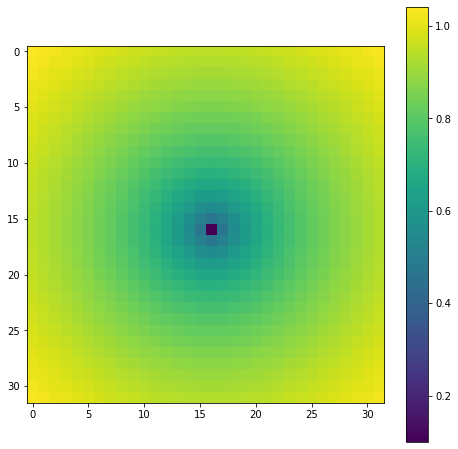

In [24]:
P = get_preconditioner(x_grid) 
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 0.1
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [25]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [26]:
#sys.stdout = sys.__stdout__

  sgd epoch 0: mean gradient = 1.316886613526303e-07
  sgd epoch 50: mean gradient = 1.304054488060209e-08
  sgd epoch 100: mean gradient = 2.4758797285698934e-08
  sgd epoch 150: mean gradient = 8.697812173768557e-09


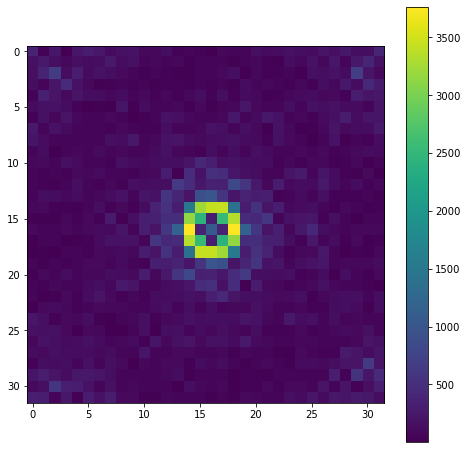

Iter  0
  Time orientations sampling = 2.3136656284332275
  sgd epoch 0: mean gradient = 4.287758464608482e-06
  sgd epoch 50: mean gradient = 7.502340239826279e-09
  Time vol optimisation = 11.153180837631226


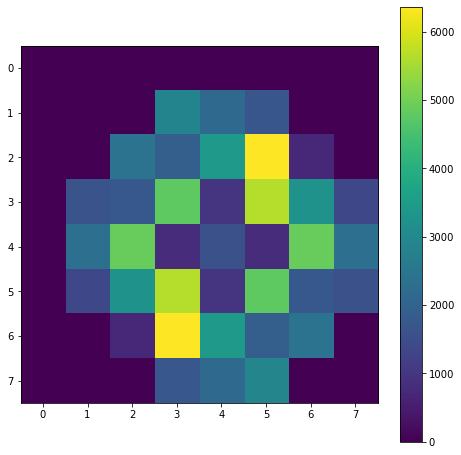

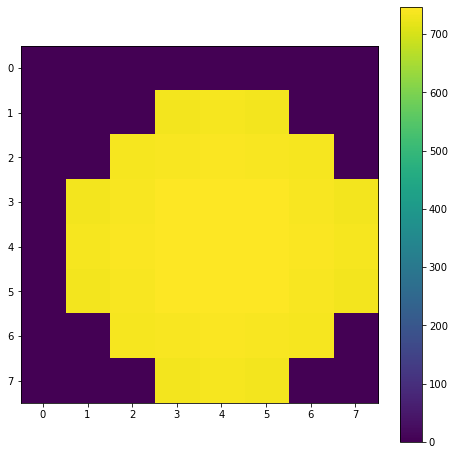

2022-02-17 18:47:24.198957
  nx = 8


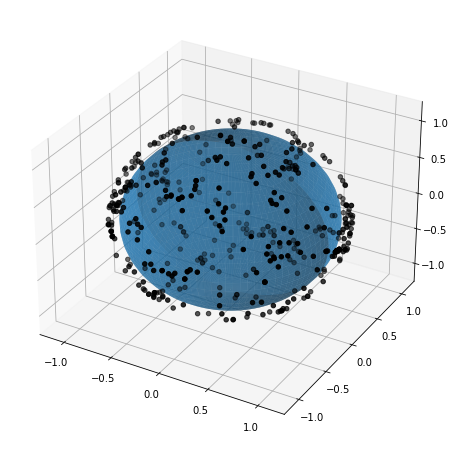

Iter  1
  Time orientations sampling = 2.4115188121795654
  sgd epoch 0: mean gradient = 1.5666189159727107e-06
  sgd epoch 50: mean gradient = 4.8987587235351774e-09
  Time vol optimisation = 12.40668272972107
Iter  2
  Time orientations sampling = 2.390659809112549
  sgd epoch 0: mean gradient = 1.5512726275100422e-06
  sgd epoch 50: mean gradient = 3.796097422137963e-09
  Time vol optimisation = 11.828648805618286
Iter  3
  Time orientations sampling = 2.2702651023864746
  sgd epoch 0: mean gradient = 1.5516016191313546e-06
  sgd epoch 50: mean gradient = 2.937937216883314e-09
  Time vol optimisation = 15.413759469985962
Iter  4
  Time orientations sampling = 2.3010737895965576
  sgd epoch 0: mean gradient = 1.5544734584348464e-06
  sgd epoch 50: mean gradient = 3.793963438710829e-09
  Time vol optimisation = 12.059695482254028
Iter  5
  Time orientations sampling = 2.5070860385894775
  sgd epoch 0: mean gradient = 1.5549438111471778e-06
  sgd epoch 50: mean gradient = 3.31298282097

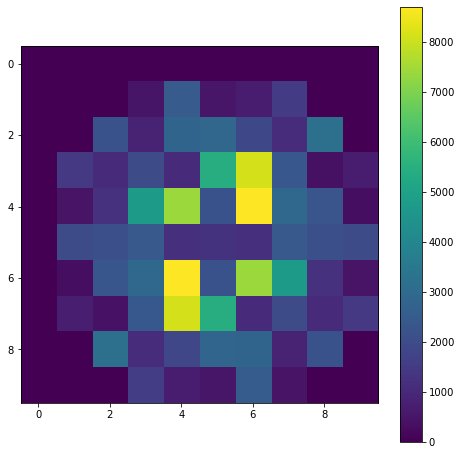

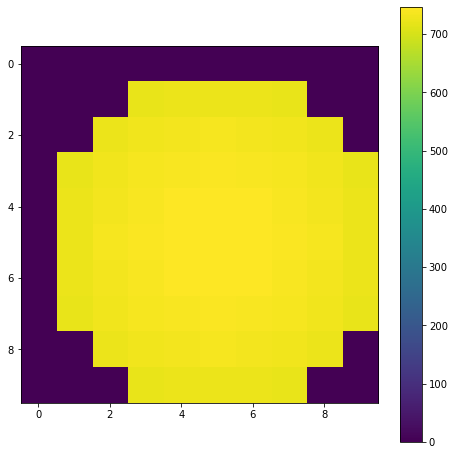

2022-02-17 18:49:27.801164
  nx = 10


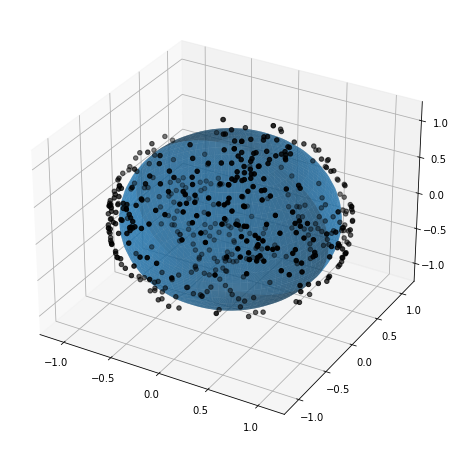

Iter  9
  Time orientations sampling = 2.344090461730957
  sgd epoch 0: mean gradient = 3.5622014371574876e-07
  sgd epoch 50: mean gradient = 1.6062490078365176e-09
  Time vol optimisation = 14.236440658569336
Iter  10
  Time orientations sampling = 2.446964740753174
  sgd epoch 0: mean gradient = 3.660231627491486e-07
  sgd epoch 50: mean gradient = 1.0070515810196452e-10
  Time vol optimisation = 14.357518911361694
Iter  11
  Time orientations sampling = 5.915616750717163
  sgd epoch 0: mean gradient = 3.59801103220343e-07
  sgd epoch 50: mean gradient = 1.2284410655675355e-09
  Time vol optimisation = 14.219075202941895
Iter  12
  Time orientations sampling = 2.395077705383301
  sgd epoch 0: mean gradient = 3.5610727901597695e-07
  sgd epoch 50: mean gradient = 1.3620678120806459e-09
  Time vol optimisation = 14.036399126052856
Iter  13
  Time orientations sampling = 2.3553833961486816
  sgd epoch 0: mean gradient = 3.567434894771311e-07
  sgd epoch 50: mean gradient = 1.1064330398

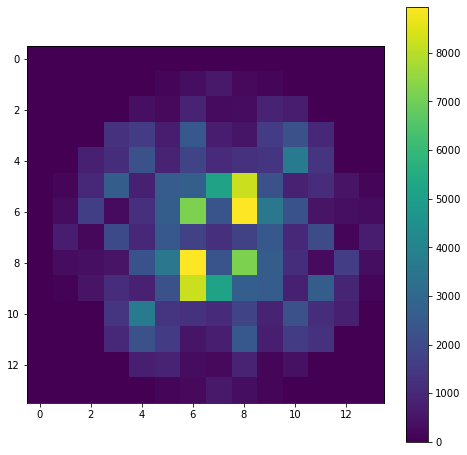

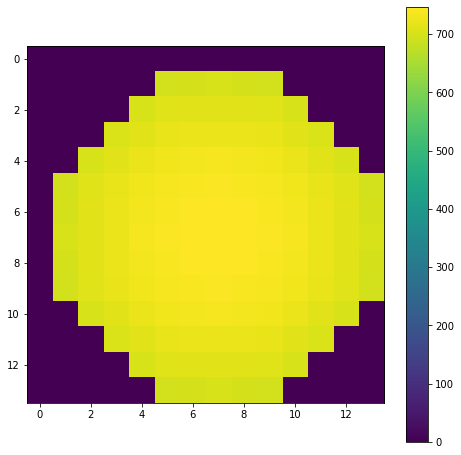

2022-02-17 18:51:49.168225
  nx = 14


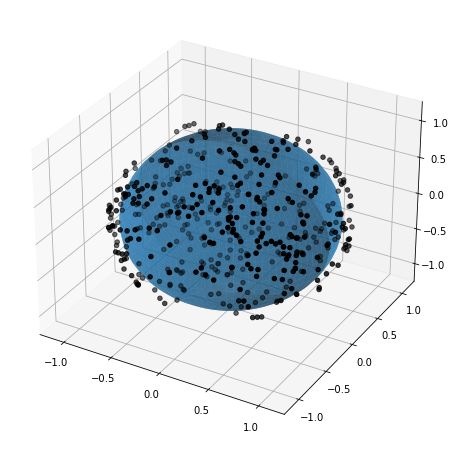

Iter  17
  Time orientations sampling = 3.300161838531494
  sgd epoch 0: mean gradient = 3.820762679345467e-07
  sgd epoch 50: mean gradient = 1.347218175691218e-10
  Time vol optimisation = 15.233612775802612
Iter  18
  Time orientations sampling = 5.707659482955933
  sgd epoch 0: mean gradient = 3.8834174621491505e-07
  sgd epoch 50: mean gradient = 1.608134423907236e-09
  Time vol optimisation = 14.549031019210815
Iter  19
  Time orientations sampling = 2.3070592880249023
  sgd epoch 0: mean gradient = 3.8930753523521506e-07
  sgd epoch 50: mean gradient = 2.9322578041182164e-10
  Time vol optimisation = 14.157452583312988
Iter  20
  Time orientations sampling = 2.2909858226776123
  sgd epoch 0: mean gradient = 3.89414339587154e-07
  sgd epoch 50: mean gradient = 8.555533005134256e-10
  Time vol optimisation = 14.52128791809082
Iter  21
  Time orientations sampling = 2.36580228805542
  sgd epoch 0: mean gradient = 3.8933960690085286e-07
  sgd epoch 50: mean gradient = 8.824658943257

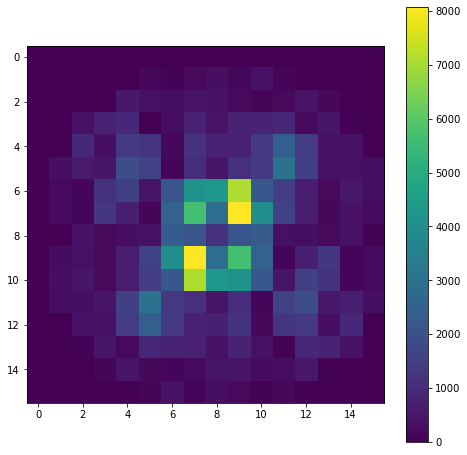

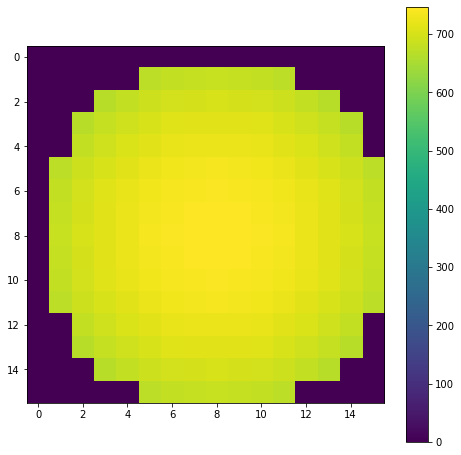

2022-02-17 18:54:12.884554
  nx = 16


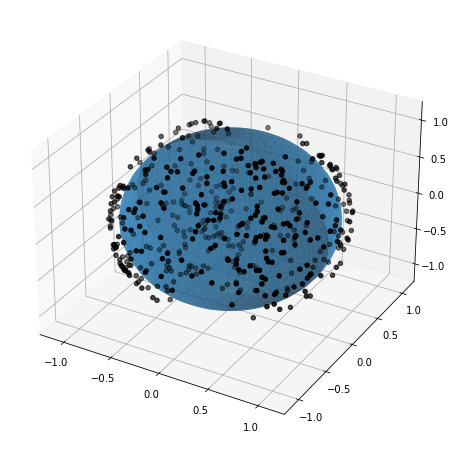

Iter  25
  Time orientations sampling = 5.501452684402466
  sgd epoch 0: mean gradient = 3.217710368346139e-07
  sgd epoch 50: mean gradient = 5.725971957518951e-10
  Time vol optimisation = 15.833996534347534
Iter  26
  Time orientations sampling = 2.352971315383911
  sgd epoch 0: mean gradient = 3.2933790680940053e-07
  sgd epoch 50: mean gradient = 2.48762053579571e-09
  Time vol optimisation = 15.974892854690552
Iter  27
  Time orientations sampling = 2.2981116771698
  sgd epoch 0: mean gradient = 3.1142137305226873e-07
  sgd epoch 50: mean gradient = 1.5225674964241889e-09
  Time vol optimisation = 16.095824480056763
Iter  28
  Time orientations sampling = 2.4323081970214844
  sgd epoch 0: mean gradient = 3.0227271456847813e-07
  sgd epoch 50: mean gradient = 3.7567499907475e-09
  Time vol optimisation = 16.201961278915405
Iter  29
  Time orientations sampling = 2.52455735206604
  sgd epoch 0: mean gradient = 2.9245560116799717e-07
  sgd epoch 50: mean gradient = 3.553748116499375

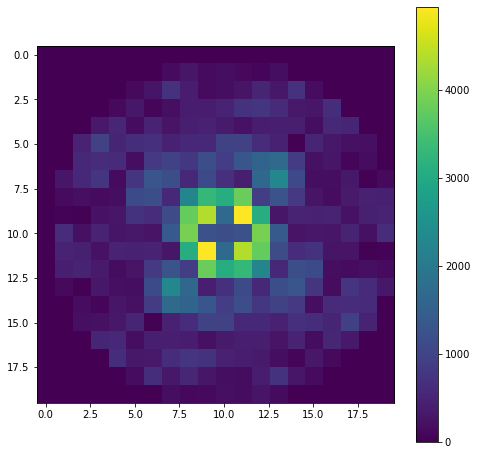

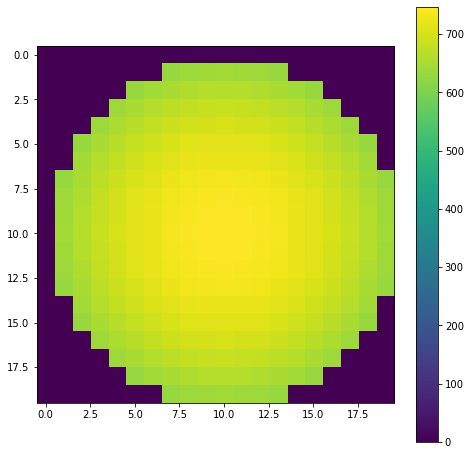

2022-02-17 18:56:49.601529
  nx = 20


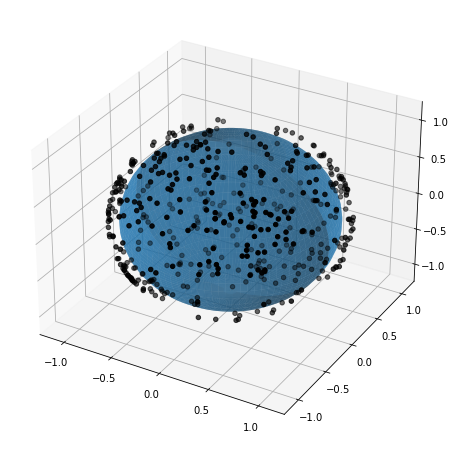

Iter  33
  Time orientations sampling = 2.29539155960083
  sgd epoch 0: mean gradient = 2.698010784333069e-07
  sgd epoch 50: mean gradient = 2.534268070692643e-09
  Time vol optimisation = 19.316641569137573
Iter  34
  Time orientations sampling = 2.28718638420105
  sgd epoch 0: mean gradient = 2.678458363409534e-07
  sgd epoch 50: mean gradient = 3.0806690084771735e-09
  Time vol optimisation = 19.110868453979492
Iter  35
  Time orientations sampling = 2.2542099952697754
  sgd epoch 0: mean gradient = 2.7287279776946825e-07
  sgd epoch 50: mean gradient = 4.852377259023835e-09
  Time vol optimisation = 19.48870611190796
Iter  36
  Time orientations sampling = 2.6383004188537598
  sgd epoch 0: mean gradient = 2.750715284189482e-07
  sgd epoch 50: mean gradient = 3.3378700877571316e-09
  Time vol optimisation = 19.622438192367554
Iter  37
  Time orientations sampling = 2.323746681213379
  sgd epoch 0: mean gradient = 2.7527022987490445e-07
  sgd epoch 50: mean gradient = 4.388200350204

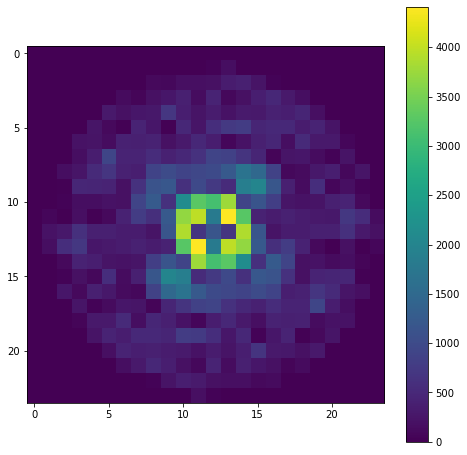

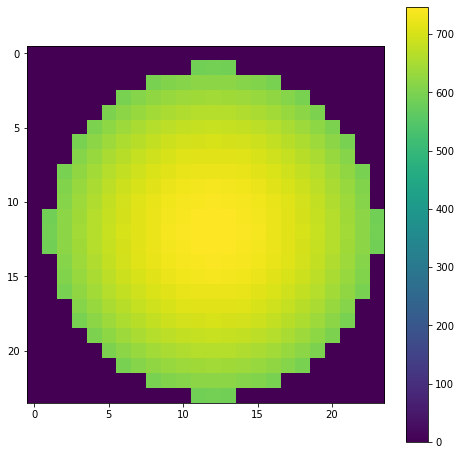

2022-02-17 18:59:50.493073
  nx = 24


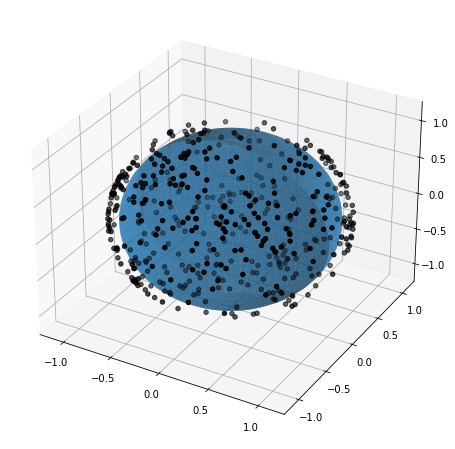

Iter  41
  Time orientations sampling = 2.2450122833251953
  sgd epoch 0: mean gradient = 2.0943188412846048e-07
  sgd epoch 50: mean gradient = 5.920340118419726e-09
  Time vol optimisation = 21.310832500457764
Iter  42
  Time orientations sampling = 2.387552261352539
  sgd epoch 0: mean gradient = 2.1031814843633759e-07
  sgd epoch 50: mean gradient = 8.103555253139988e-09
  Time vol optimisation = 21.250176906585693
Iter  43
  Time orientations sampling = 2.2591986656188965
  sgd epoch 0: mean gradient = 2.033388164908252e-07
  sgd epoch 50: mean gradient = 3.1054114519803614e-09
  Time vol optimisation = 23.2668616771698
Iter  44
  Time orientations sampling = 2.37746524810791
  sgd epoch 0: mean gradient = 2.1537372488528838e-07
  sgd epoch 50: mean gradient = 5.487752424417814e-10
  Time vol optimisation = 23.482563972473145
Iter  45
  Time orientations sampling = 2.4653844833374023
  sgd epoch 0: mean gradient = 2.2277718090304867e-07
  sgd epoch 50: mean gradient = 1.3116071891

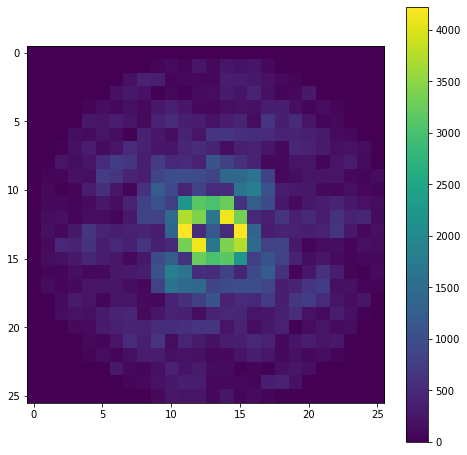

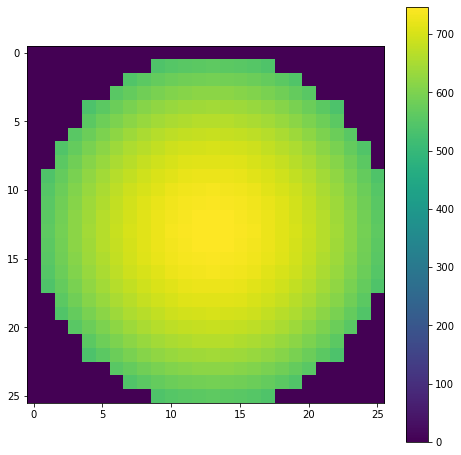

2022-02-17 19:03:26.723947
  nx = 26


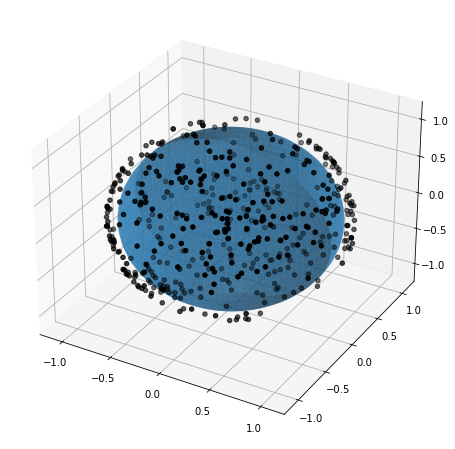

Iter  49
  Time orientations sampling = 2.396530866622925
  sgd epoch 0: mean gradient = 1.6855595916457686e-07
  sgd epoch 50: mean gradient = 4.239177068126162e-09
  Time vol optimisation = 27.238943576812744
Iter  50
  Time orientations sampling = 2.3678576946258545
  sgd epoch 0: mean gradient = 1.5874960657389006e-07
  sgd epoch 50: mean gradient = 3.0789684114010056e-09
  Time vol optimisation = 29.584407806396484
Iter  51
  Time orientations sampling = 2.425701141357422
  sgd epoch 0: mean gradient = 1.617324585647118e-07
  sgd epoch 50: mean gradient = 2.8802055729170957e-09
  Time vol optimisation = 28.949084043502808
Iter  52
  Time orientations sampling = 2.3113574981689453
  sgd epoch 0: mean gradient = 1.7046338773355317e-07
  sgd epoch 50: mean gradient = 9.620164005151131e-10
  Time vol optimisation = 29.28297781944275
Iter  53
  Time orientations sampling = 2.459043502807617
  sgd epoch 0: mean gradient = 1.687185875873126e-07
  sgd epoch 50: mean gradient = 4.946499808

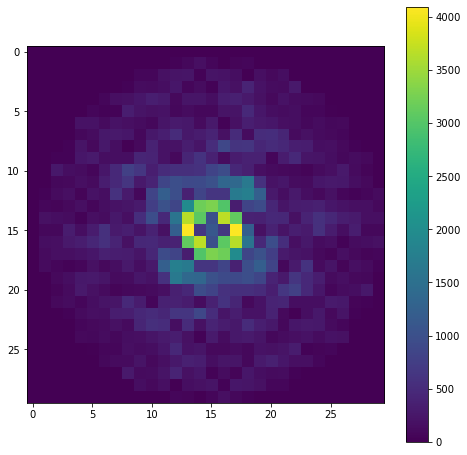

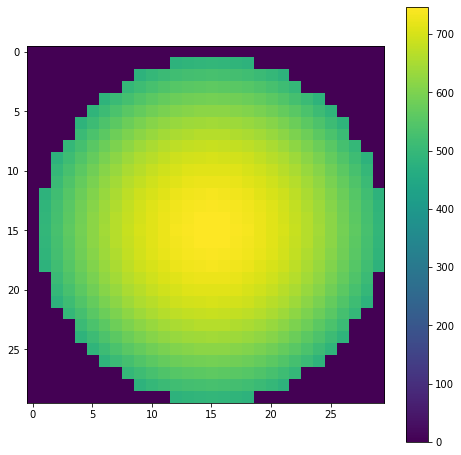

2022-02-17 19:07:41.255575
  nx = 30


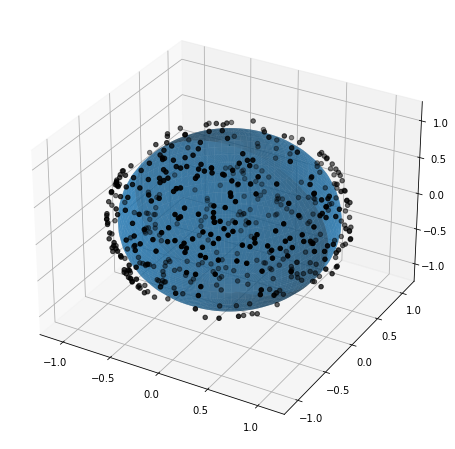

Iter  57
  Time orientations sampling = 2.53570556640625
  sgd epoch 0: mean gradient = 1.444158154662271e-07
  sgd epoch 50: mean gradient = 2.049818905933586e-09
  Time vol optimisation = 28.639102458953857
Iter  58
  Time orientations sampling = 2.3164002895355225
  sgd epoch 0: mean gradient = 1.3532430488774632e-07
  sgd epoch 50: mean gradient = 2.1623754574064924e-09
  Time vol optimisation = 28.35869812965393
Iter  59
  Time orientations sampling = 2.3483808040618896
  sgd epoch 0: mean gradient = 1.5249900908474506e-07
  sgd epoch 50: mean gradient = 6.857077428216389e-09
  Time vol optimisation = 28.19994878768921
Iter  60
  Time orientations sampling = 2.256591320037842
  sgd epoch 0: mean gradient = 1.298246960918116e-07
  sgd epoch 50: mean gradient = 1.1407046563035665e-08
  sgd epoch 100: mean gradient = 1.9131092343418845e-08
  sgd epoch 150: mean gradient = 3.91921845117854e-09
  Time vol optimisation = 49.436638832092285
Iter  61
  Time orientations sampling = 2.32883

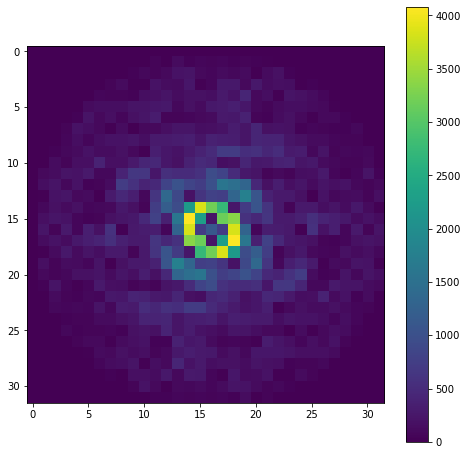

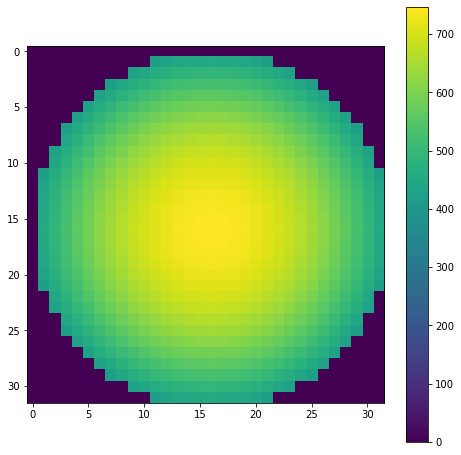

2022-02-17 19:12:17.447051
  nx = 32


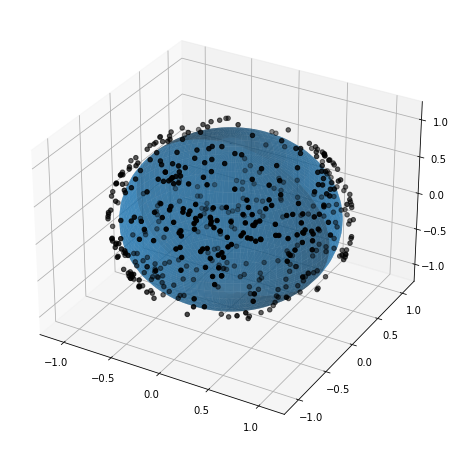

In [695]:
N_samples = 40000
N_iter = 10000

dr = 0.005
#dr = 0.003
radius = 0.01
#radius = 0.03
alpha = 1e-7 /100 # <--- this is the working one
#alpha = 1e-6

use_sgd = True

N_cg_iter = 10000
eps_cg = 3e-5
#eps_cg = 1e-4

N_sgd_iter = 100000
batch_size = 300
#learning_rate = 100
learning_rate = 10000 * 100
P = None
#eps_gd = 3e-8
eps_gd = 1e-6 / 100
#eps_gd = 1e-4

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])


v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

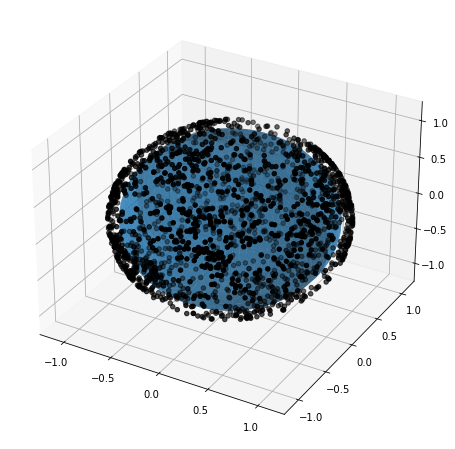

In [696]:
plot_angles(angles_rec[:2000])

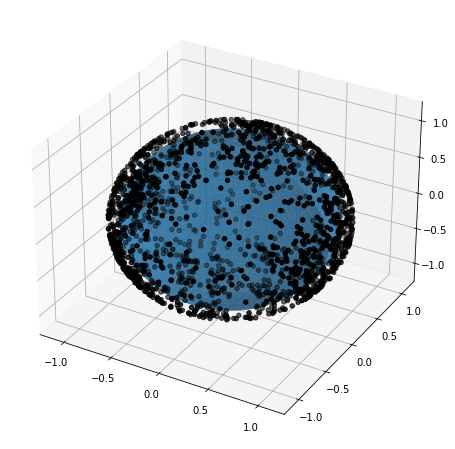

In [240]:
plot_angles(angles_rec[:2000])

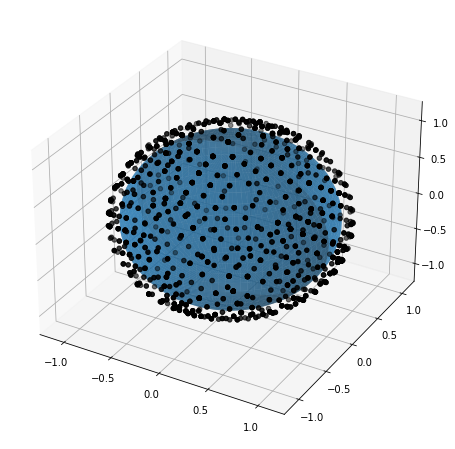

In [31]:
plot_angles(angles[:2000])

### CG

In [50]:
alpha = 1e-4
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
#sigma_noise = jnp.max(sigma_noise) * jnp.ones(sigma_noise.shape)

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 101

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape, sigma_noise)

In [51]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 2.229473759128272e-05
  cg iter 50 ||r|| = 5.431257166781235e-07
  cg iter 100 ||r|| = 3.6602226546659477e-07


In [52]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vcg1, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))/(nx*nx))

Final loss function (over all data) =  2.2127388709015983


In [39]:
l2sq(vcg1)*alpha/2

DeviceArray(0.5374013, dtype=float64)

In [295]:
#sgd_loss_func(vcg1, jnp.arange(N))

In [296]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [40]:
i = 110
s0 = slice_func(v_rec, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

NameError: name 'v_rec' is not defined

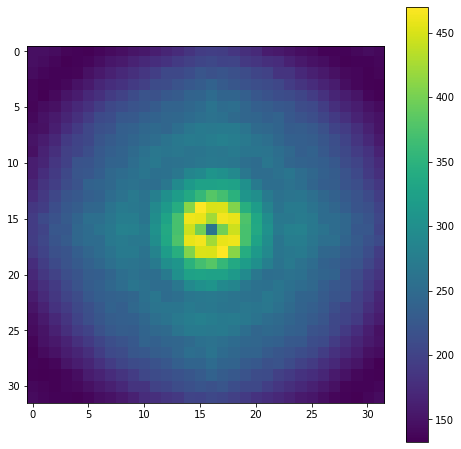

In [41]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

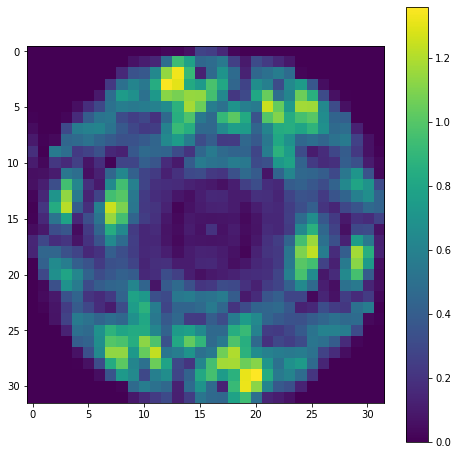

In [42]:
i = 100
s0 = slice_func(vcg1, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

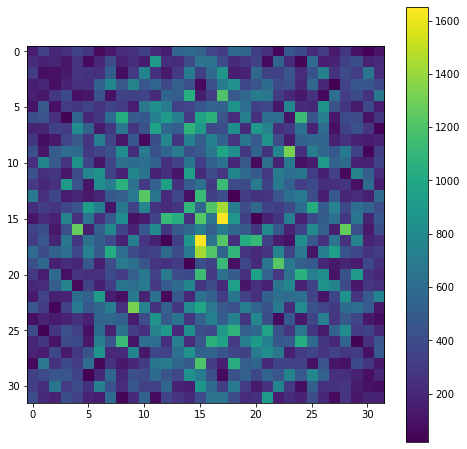

In [43]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[i]).reshape(nx,nx))); plt.colorbar()

In [44]:
resid = s0 - imgs_f[i]
d = jnp.real(jnp.conj(resid)*resid)/(2*sigma_noise**2)

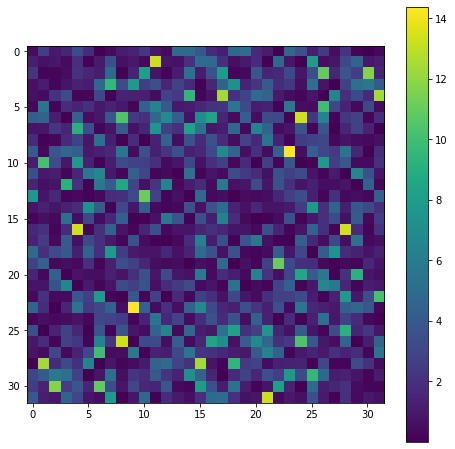

In [45]:
plt.imshow(jnp.fft.fftshift(d.reshape([32,32]))); plt.colorbar()

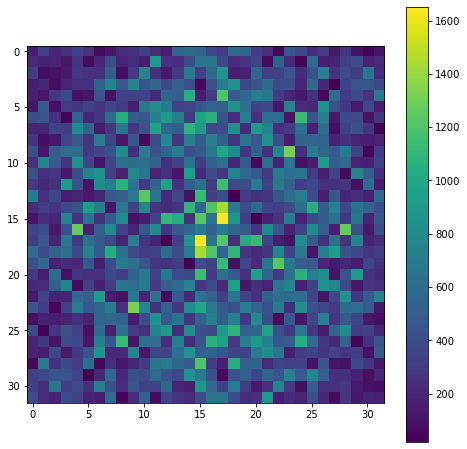

In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(resid.reshape([32,32])))); plt.colorbar()

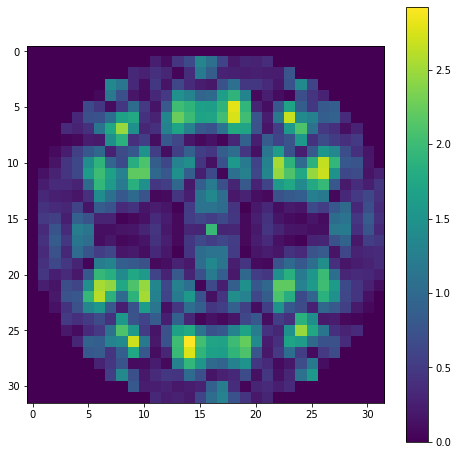

In [47]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

In [48]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

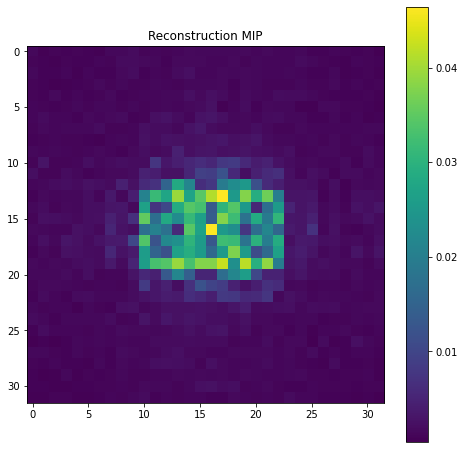

In [49]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [319]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

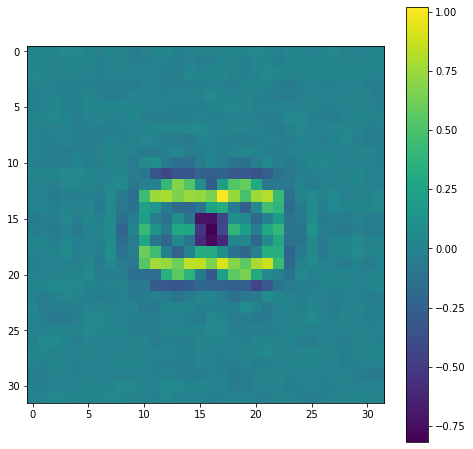

In [320]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

In [321]:
verr = vcg1 - v_rec
plt.imshow(jnp.abs(jnp.fft.fftshift(verr[0,:,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [322]:
jnp.max(jnp.abs(vcg1))

DeviceArray(116.88976, dtype=float64)

In [323]:
jnp.max(jnp.abs(v_rec))

NameError: name 'v_rec' is not defined

### Write volume to file

In [324]:
with mrcfile.new('../data/reconstruction_data_32_cg.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### CG - choosing $\alpha$

In [449]:
alpha

1e-08

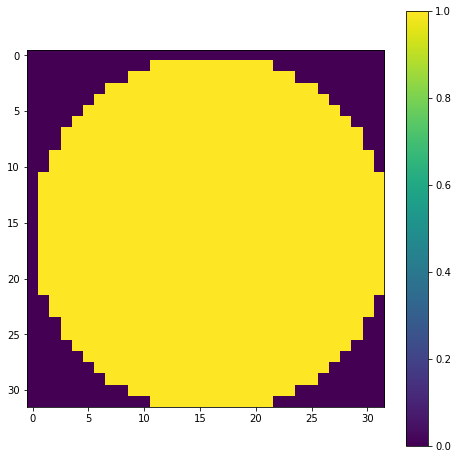

In [450]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [451]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

Estimate the noise:

sigma noise min = 305.89374
sigma noise max = 746.633
sigma noise mean = 471.57767


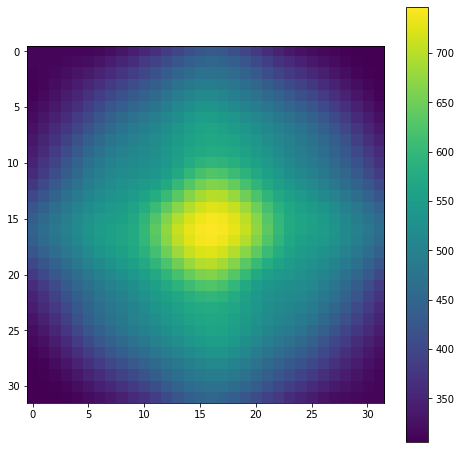

In [452]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [454]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [476]:
N_iter = 50100
#eps = 3e-5
eps = 1e-5
#eps = 1e-4
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
alphas = [1e-10, 1e-9, 1e-8]
vcgs = []
fids = []
regs = []
losss = []

angles_cg = angles_rec

In [477]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-10
  cg iter 0 ||r|| = 0.001112034388737925
  cg iter 50 ||r|| = 0.0014110579532509897
  cg iter 100 ||r|| = 0.0009752007197904259
  cg iter 150 ||r|| = 0.0008233366093695644
  cg iter 200 ||r|| = 0.0007379875450188475
  cg iter 250 ||r|| = 0.0006012156192906719
  cg iter 300 ||r|| = 0.0006041981265454005
  cg iter 350 ||r|| = 0.0005431241396059616
  cg iter 400 ||r|| = 0.0005334050437579942
  cg iter 450 ||r|| = 0.00047636675839177515
  cg iter 500 ||r|| = 0.0004280278496148507
  cg iter 550 ||r|| = 0.00045402993880467056
  cg iter 600 ||r|| = 0.00043274879559528025
  cg iter 650 ||r|| = 0.0003909917381993812
  cg iter 700 ||r|| = 0.0003919296358517088
  cg iter 750 ||r|| = 0.00038017795007122426
  cg iter 800 ||r|| = 0.00035687109762257683
  cg iter 850 ||r|| = 0.00032869793011945924
  cg iter 900 ||r|| = 0.00033535562857523756
  cg iter 950 ||r|| = 0.00035167418694947354
  cg iter 1000 ||r|| = 0.00031295953044383466
  cg iter 1050 ||r|| = 0.00032780909146092627
  cg iter 

KeyboardInterrupt: 

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids[1:])

In [ ]:
plt.semilogy(regs[1:])

In [461]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

Pixel-wise loss for the best reconstruction:

In [462]:
alphas[alpha_idx]

DeviceArray(1.e-08, dtype=float64)

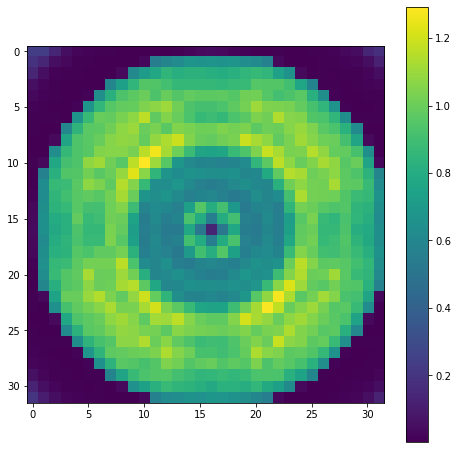

In [463]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

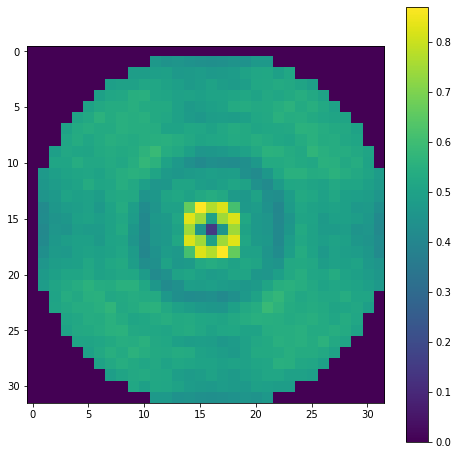

In [464]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [465]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

2


In [469]:
#alpha_idx = 2

1e-08


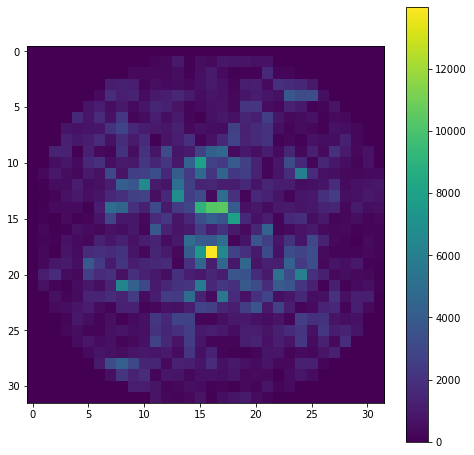

In [470]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

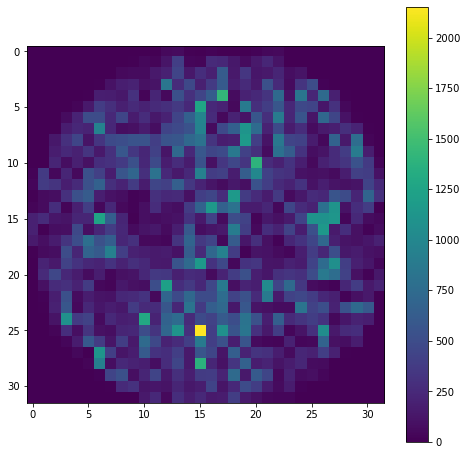

In [471]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

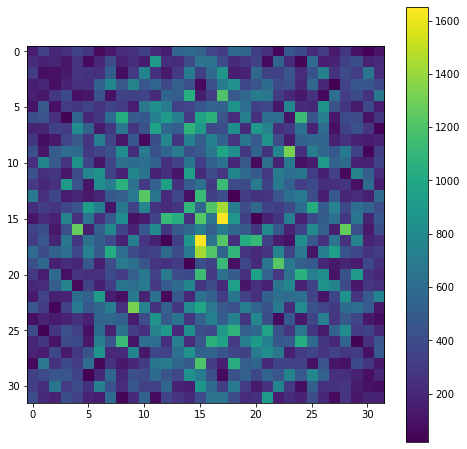

In [472]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

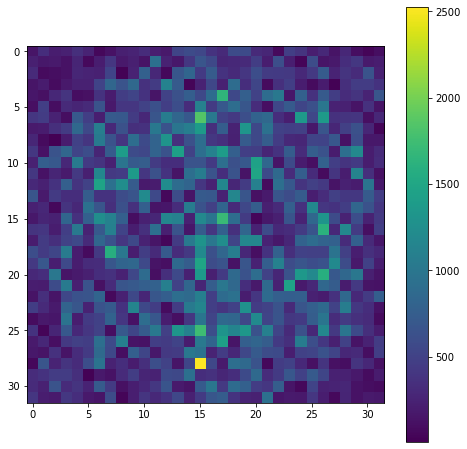

In [473]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

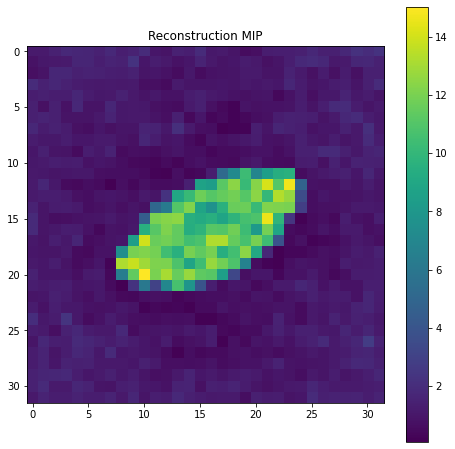

In [474]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

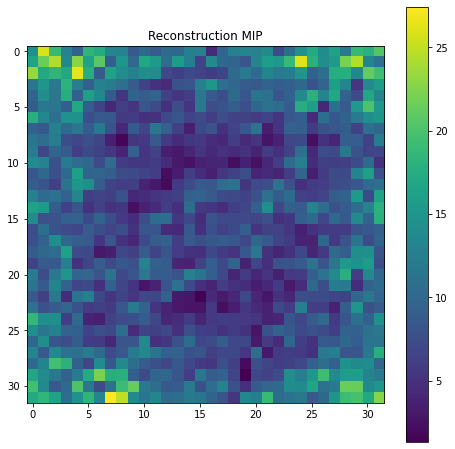

In [475]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')

In [262]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha2.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [263]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(11, 32)

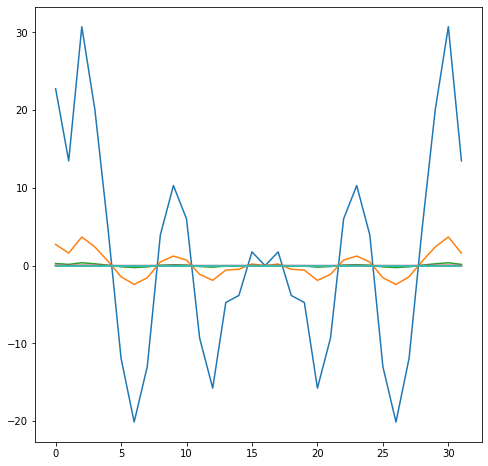

In [264]:
for i in range(1,11):
    plt.plot(jnp.real(vcgs_s[i]))

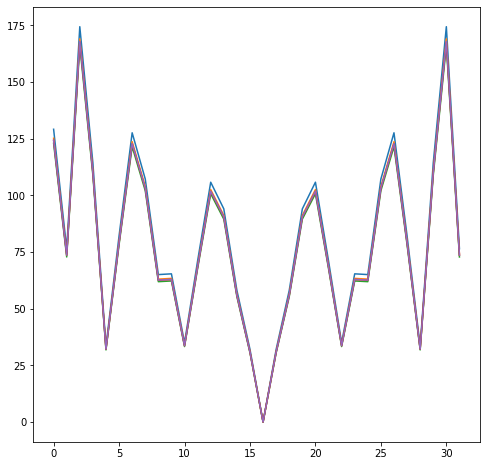

In [265]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*5.5)
plt.plot(jnp.abs(vcgs_s[2])*45)
plt.plot(jnp.abs(vcgs_s[3])*450)
plt.plot(jnp.abs(vcgs_s[10])*4.5e9)


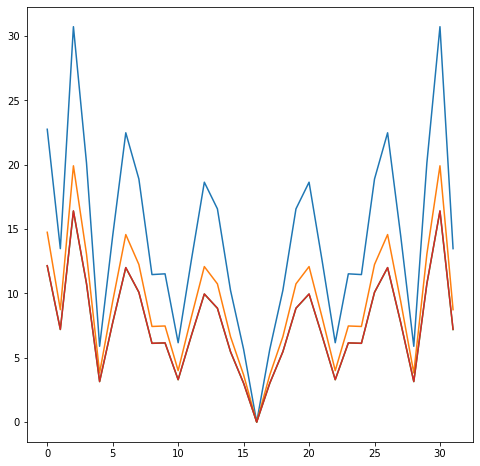

In [266]:
#plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1]))
plt.plot(jnp.abs(vcgs_s[2])*5.4)
plt.plot(jnp.abs(vcgs_s[3])*44)
plt.plot(jnp.abs(vcgs_s[10])*4.4e8)

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


In [153]:
angles[:50].shape

(50, 3)

In [21]:
rc = rotate_list(x_grid, angles[:2])
_,(_,xyz_idxs) = jax.vmap(find_nearest_eight_grid_points_idx, in_axes = (1,None, None, None))(rc, x_grid, x_grid, x_grid)

In [29]:
#jnp.array_split(xyz_idxs, 100)

In [28]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


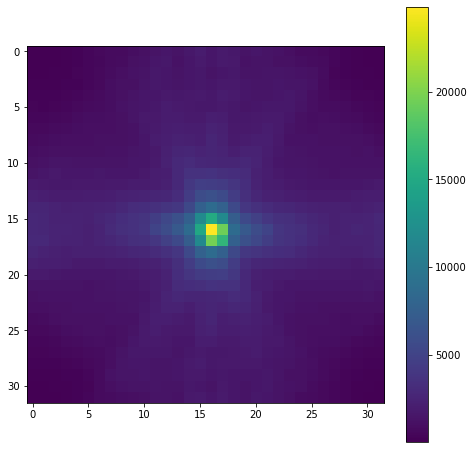

In [18]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

In [69]:
points_v_nn.shape
P2 = points_v_nn
P2 += 1
P2 = (1/P2**0.1 ) * mask

P2 = P2/jnp.max(P2)

plt.imshow(jnp.fft.fftshift(P2[:,:,0]));plt.colorbar()
print(P2[0,0,0])
print(jnp.max(P2))
print(jnp.min(P2))

NameError: name 'points_v_nn' is not defined

1e-06
1.000001
1e-06


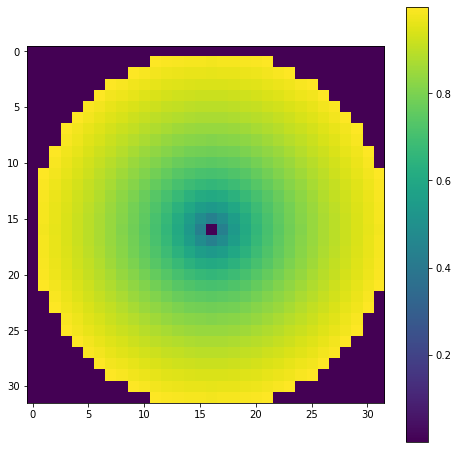

In [34]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


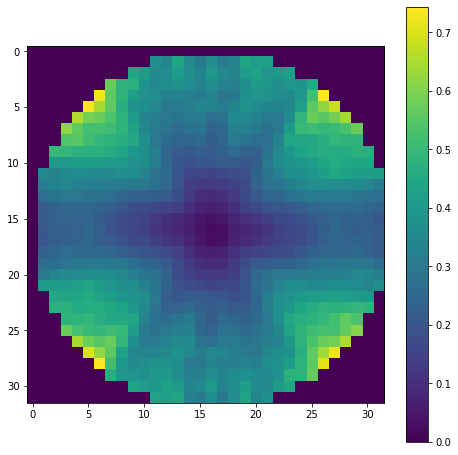

In [29]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [697]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [748]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-6 / 100
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-5, 1e-4, 1e-3]
#alphas = [1e-13]


angles_gd = angles_rec

In [749]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-05
  sgd epoch 0: mean gradient = 1.1562523292166486e-07
  sgd epoch 50: mean gradient = 2.2140516599693593e-09
  fid = 0.6037536839154194
  reg = 0.9743341813980286
  loss = 0.30203273542673337
  Time = 23.50323510169983
alpha = 0.0001
  sgd epoch 0: mean gradient = 5.989830231638708e-08
  sgd epoch 50: mean gradient = 1.001246994895529e-07
  sgd epoch 100: mean gradient = 9.542440804369961e-08
  sgd epoch 150: mean gradient = 1.6778449485386523e-08
  sgd epoch 200: mean gradient = 2.982588935148081e-08
  sgd epoch 250: mean gradient = 1.2133357208989389e-08
  sgd epoch 300: mean gradient = 4.053585681287583e-08
  sgd epoch 350: mean gradient = 1.6699946149869027e-08
  sgd epoch 400: mean gradient = 1.6179061872075057e-09
  fid = 0.604314010857134
  reg = 0.014015192043811193
  loss = 0.3021794297358371
  Time = 92.85766649246216
alpha = 0.001
  sgd epoch 0: mean gradient = 125618538.37104648
  sgd epoch 50: mean gradient = nan
  sgd epoch 100: mean gradient = nan


KeyboardInterrupt: 

In [750]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

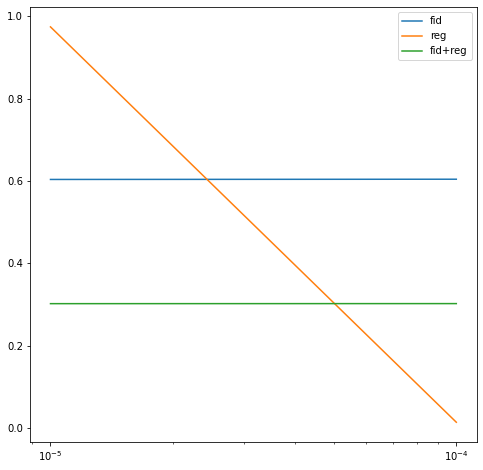

In [751]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

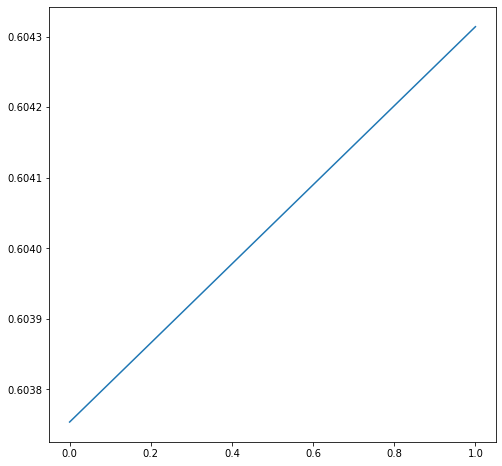

In [752]:
plt.plot(fids)

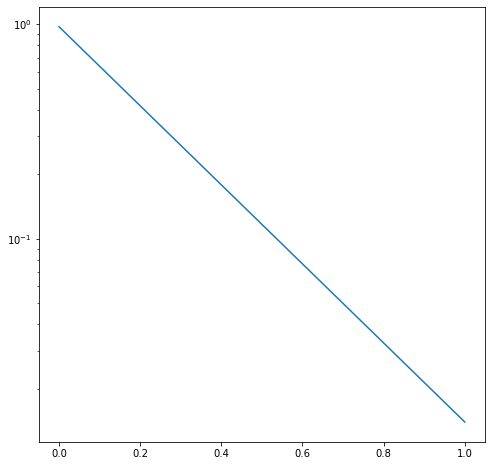

In [753]:
plt.semilogy(regs)

In [754]:
alphas[2]

DeviceArray(0.001, dtype=float64)

In [783]:
#alpha_idx= 3
#alpha_idx=5
alpha_idx=0

0.8142035851593756


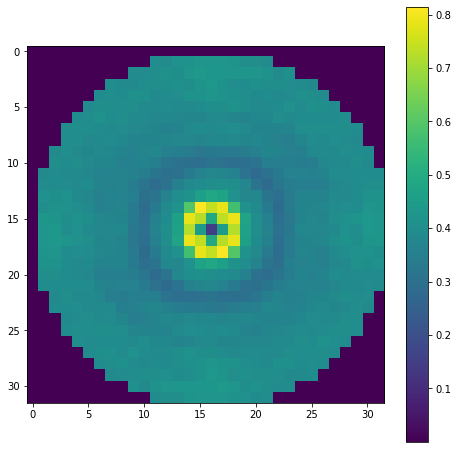

In [784]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.8142035851593756


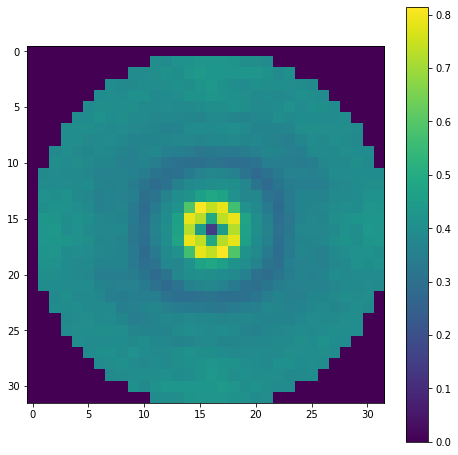

In [785]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

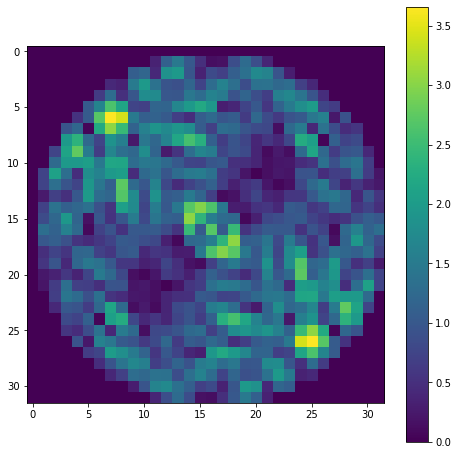

In [786]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

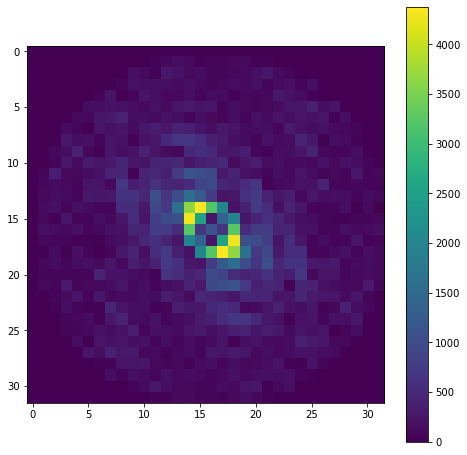

In [787]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

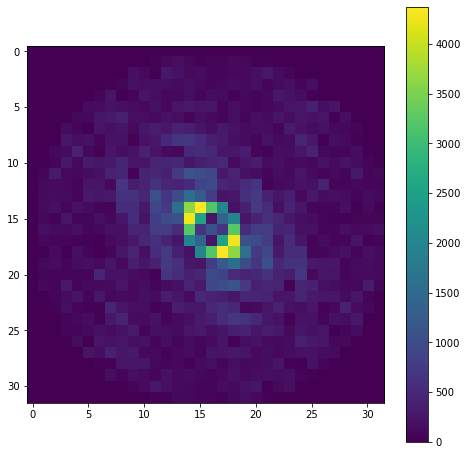

In [788]:
err = vgds[alpha_idx] - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [789]:
alphas[5]

DeviceArray(0.001, dtype=float64)

In [790]:
vgds.shape

(2, 32, 32, 32)

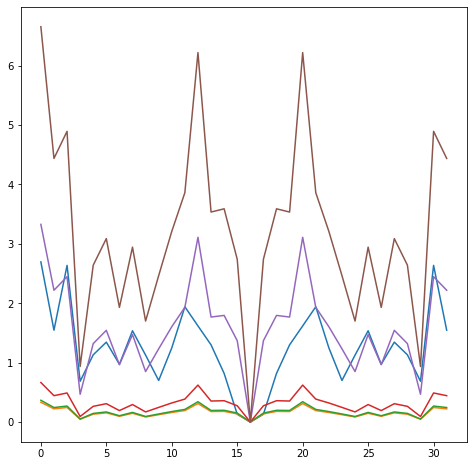

In [791]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1]))
plt.plot(jnp.abs(vgds_s[2])*1.1)
plt.plot(jnp.abs(vgds_s[3])*2)
plt.plot(jnp.abs(vgds_s[4])*10)
plt.plot(jnp.abs(vgds_s[5])*20)

#plt.plot(jnp.abs(vgds_s[10])*4.5e9)

In [792]:
alphas

DeviceArray([1.e-05, 1.e-04, 1.e-03], dtype=float64)

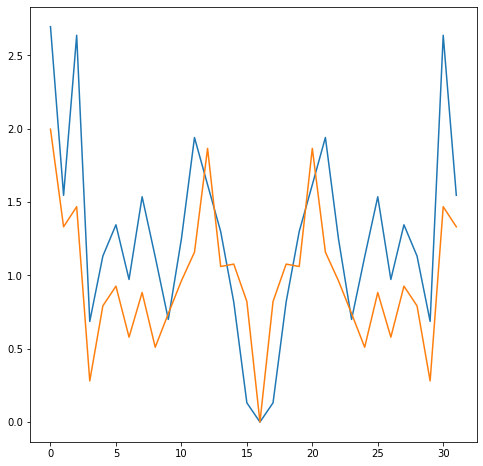

In [793]:
plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*6)
#plt.plot(jnp.abs(vgds_s[2])*2)
#plt.plot(jnp.abs(vgds_s[3])*1.5)
#plt.plot(jnp.abs(vgds_s[4])*4)
#plt.plot(jnp.abs(vgds_s[5])*20)


In [794]:
jnp.max(jnp.abs(imgs_f))

DeviceArray(5328.8518801, dtype=float64)

In [799]:
alphas[2]

DeviceArray(0.001, dtype=float64)

In [800]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))

In [801]:
alphas[alpha_idx]

DeviceArray(1.e-05, dtype=float64)

Text(0.5, 1.0, 'Reconstruction MIP')

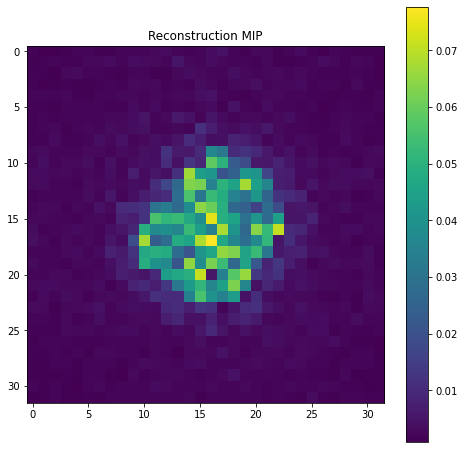

In [802]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

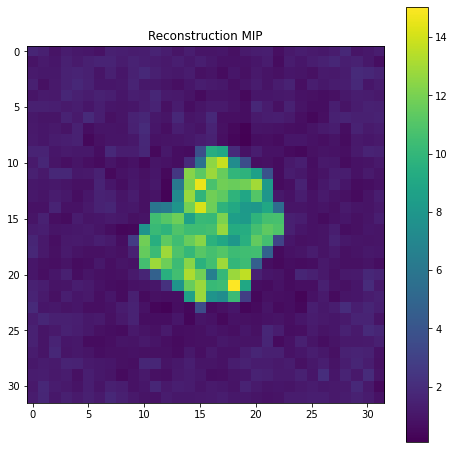

In [803]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [804]:
with mrcfile.new('../data/reconstruction_data_32_sgd4.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [780]:
idx = 100

In [781]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles[idx], shifts[idx], ctf_params[idx])

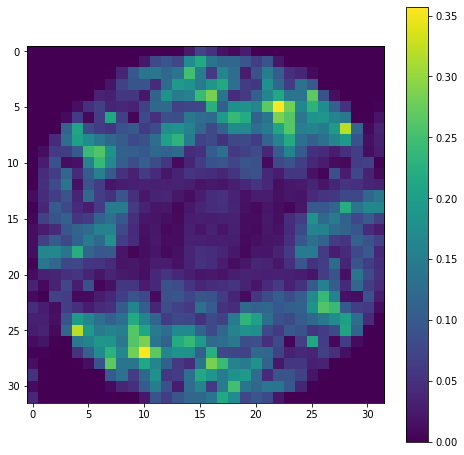

In [782]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

In [602]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

NameError: name 'slicerec' is not defined

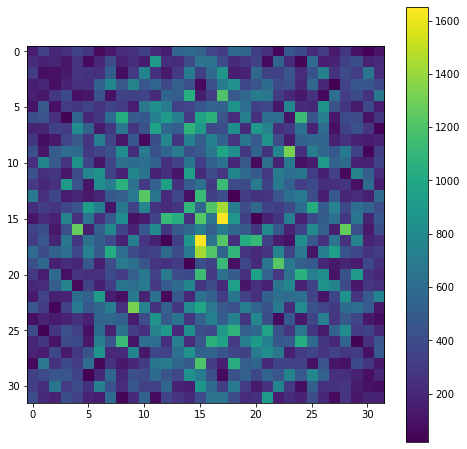

In [603]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [134]:
print(1/2*wl2sq(slicegd, imgs_f[idx], 1/sigma_noise**2))
print(1/2*wl2sq(slicerec, imgs_f[idx], 1/sigma_noise**2))

553.343876582564


NameError: name 'slicerec' is not defined

In [355]:
lossgd = loss_func_sum(vgd, angles, shifts, ctf_params, imgs_f, sigma_noise)
lossrec = loss_func_sum(v_rec, angles, shifts, ctf_params, imgs_f, sigma_noise)

print(lossgd)
print(lossrec)

NameError: name 'v_rec' is not defined

In [356]:
alpha0 = 0 

loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
grad_loss_volume0, grad_loss_volume_batched0, grad_loss_volume_sum0 = get_grad_v_funcs(loss_func0, loss_func_sum0)

In [269]:
lossgd0 = loss_func_sum0(vgd, angles, shifts, ctf_params, imgs_f)
lossrec0 = loss_func_sum0(v_rec, angles, shifts, ctf_params, imgs_f)

print(lossgd0)
print(lossrec0)

117666.1786326568
125930.4384133436


In [270]:
reg_term = lambda v, alpha : 1/(2*v.shape[-1]**2) * alpha * l2sq(v)

In [276]:
print(reg_term(vgd, alpha) + lossgd0)
print(reg_term(v_rec, alpha) + lossrec0)

118950.80871989178
324801.5763731515


In [281]:
imgs_f.shape

(4501, 1024)

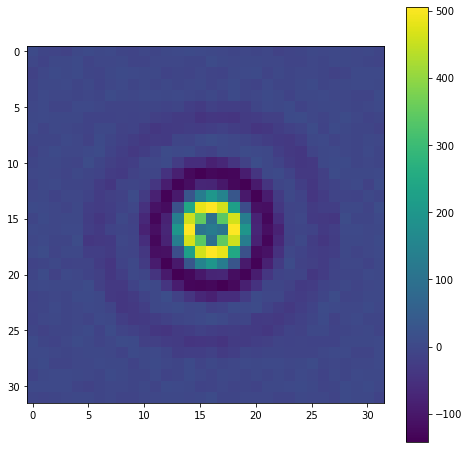

In [395]:
imgs_mean = jnp.mean(jnp.real(imgs_f), axis=0)
plt.imshow(jnp.fft.fftshift((imgs_mean.reshape([32,32]))))
plt.colorbar()

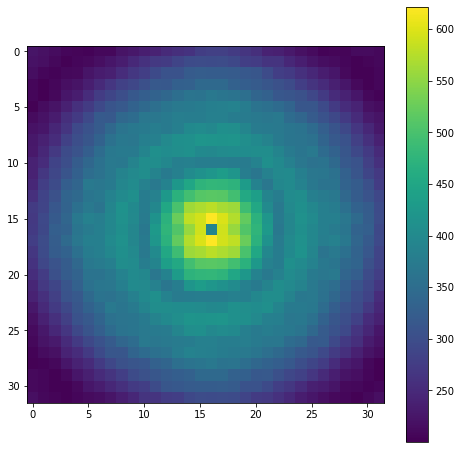

In [373]:
imgs_sd = jnp.sqrt(jnp.mean((jnp.real(imgs_f)-imgs_mean)**2, axis=0))
plt.imshow(jnp.fft.fftshift(imgs_sd.reshape([32,32])))
plt.colorbar()

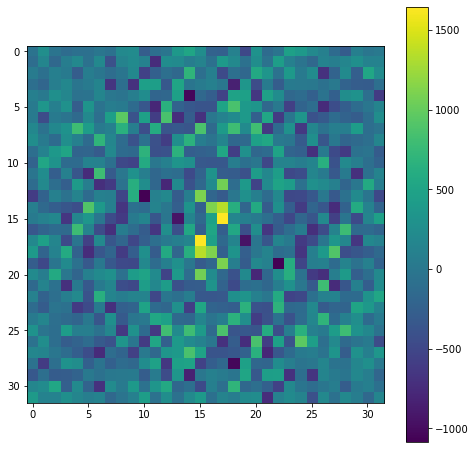

In [397]:
plt.imshow(jnp.real(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [380]:
img_idx = jnp.fft.fftshift(imgs_f[idx].reshape([32,32]))

In [443]:
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))

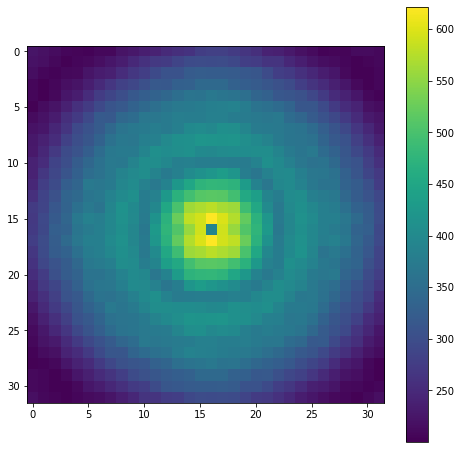

In [437]:
plt.imshow(jnp.fft.fftshift(sd_real.reshape([32,32]))); plt.colorbar()